# Imports

In [14]:
from pathlib import Path
import os
import pandas as pd
import torch as tc
import torchvision as tv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchsummary import summary as ts
import numpy as np
import torchvision.transforms as transforms
import sklearn.metrics as metrics
import seaborn as sns
from sklearn.metrics import classification_report

# Dataset and Dataloader

In [15]:
output_folder = Path(r"C:/Users/Michał/Documents/ISWD/workdir/beer_labels")

os.chdir(output_folder)

dirs = [d for d in os.listdir() if os.path.isdir(d)]

print(f"Output folder path: {output_folder}")

dataset_path = Path("C:/Users/Michał/Documents/ISWD/workdir/")
training_csv_path = os.path.join(dataset_path, "training.csv")
validation_csv_path = os.path.join(dataset_path, "validation.csv")
testing_csv_path = os.path.join(dataset_path, "testing.csv")

classes = []
for name in os.listdir(output_folder):
    dir_path = os.path.join(output_folder, name)
    if os.path.isdir(dir_path) and any(os.scandir(dir_path)):
        classes.append(name)

print("Liczba klas: " + str(len(classes)))
num_classes = len(classes)

Output folder path: C:\Users\Michał\Documents\ISWD\workdir\beer_labels
Liczba klas: 95


In [16]:
all_cases = []

for current_class in classes:
    class_path = os.path.join(output_folder, current_class)
    image_files = os.listdir(class_path)

    for i in range(len(image_files)):
        image_path = os.path.join(class_path, image_files[i])
        all_cases.append((image_path,  current_class))
      
train_cases, test_cases = train_test_split(all_cases, test_size=0.2, random_state=42)
train_cases, val_cases = train_test_split(train_cases, test_size=0.125, random_state=42)

train_df = pd.DataFrame(train_cases, columns=["image_path", "image_class_name"])
train_df.to_csv(training_csv_path)

val_df = pd.DataFrame(val_cases, columns=["image_path", "image_class_name"])
val_df.to_csv(validation_csv_path)

test_df = pd.DataFrame(test_cases, columns=["image_path", "image_class_name"])
test_df.to_csv(testing_csv_path)


In [17]:
class BeerDataset(tc.utils.data.Dataset):
    def __init__(self, dataset_path, csv_path, transforms=None, z_norm=False):
        self.dataset_path = dataset_path
        self.csv_path = csv_path
        self.dataframe = pd.read_csv(csv_path)
        self.transforms = transforms
        self.z_norm = z_norm

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.at[idx, 'image_path']
        current_class = self.dataframe.at[idx, 'image_class_name']

        current_image = tv.io.read_image(image_path)
        current_image = current_image.numpy()
        current_image = tc.from_numpy(current_image)
      

        if (len(current_image.shape) == 2):
          current_image = current_image.unsqueeze(2)
        #print(current_image.shape)
      
        if current_image.shape[2] == 1:
            current_image = current_image.repeat(1, 1, 3)
        if current_image.shape[2] == 4:
            current_image = current_image[:, :, :3]

        #current_image = current_image.permute(2, 0, 1)
        current_image = tv.transforms.functional.resize(current_image, (224,224), antialias=True)
        
        #print(current_image.shape)

        if self.transforms is not None:
          current_image = self.transforms(current_image)

        if self.z_norm:
          current_image = current_image.numpy()
          current_image = current_image.astype(np.float32)
          current_image = tc.from_numpy(current_image)
          current_image = tv.transforms.functional.normalize(current_image, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        else:
            current_image = current_image / 255.0
            current_image = (current_image - 0.5) / 0.5

        return current_image, current_class


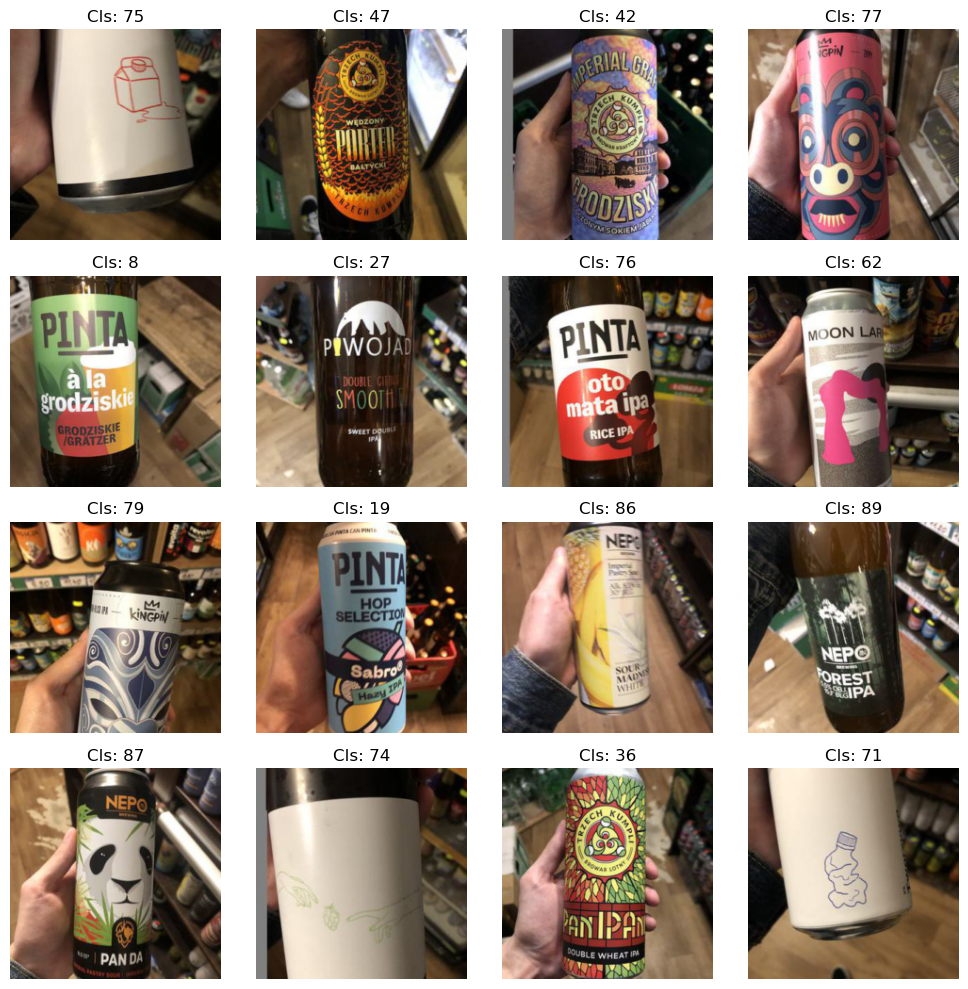

In [18]:
batch_size = 16
shuffle = True
# transforms = tc.nn.Sequential(
#   tv.transforms.AutoAugment(policy=tv.transforms.AutoAugmentPolicy.IMAGENET),
# )
dataset = BeerDataset(os.path.join(dataset_path, "tmp"), training_csv_path, z_norm=False)
dataloader = tc.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

for images, classes in dataloader:
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        image = np.transpose(images[i].numpy(), (1, 2, 0))
        image = (image + 1) / 2
        ax.set_title("Cls: " + str(classes[i].item()))
        ax.imshow(image)
        ax.axis("off")

    plt.tight_layout()
    plt.show()
    break

# Neural Networks Architectures

In [19]:
class ClassificationNetwork(tc.nn.Module):
    def __init__(self):
        super(ClassificationNetwork, self).__init__()
        self.cnn = tc.nn.Sequential(
            tc.nn.Conv2d(3, 32, 3, 1, 1),
            tc.nn.BatchNorm2d(32),
            tc.nn.ReLU(),
            tc.nn.Conv2d(32, 64, 3, 2, 2),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 64, 3, 1, 1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 64, 3, 2, 2),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 64, 3, 2, 2),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 64, 3, 2, 1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.AdaptiveAvgPool2d((1,1))
        )
        self.nn = tc.nn.Sequential(
            tc.nn.Linear(64, 64),
            tc.nn.ReLU(),
            tc.nn.Linear(64, 64),
            tc.nn.ReLU(),
            tc.nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.nn(x)
        return x

In [20]:
device = "cuda:0" if tc.cuda.is_available() else "cpu"

classification_network = ClassificationNetwork()

batch_size = 4
random_input = tc.randn((batch_size, 3, 224, 224))
random_output = classification_network(random_input)

print(f"Size of the random input: {random_input.size()}")
print(f"Size of the random output: {random_output.size()}")
print("Random output: ")
print(random_output)

print("Network summary: ")
ts(classification_network.to(device), (3, 224, 224))

Size of the random input: torch.Size([4, 3, 224, 224])
Size of the random output: torch.Size([4, 95])
Random output: 
tensor([[-0.0225,  0.0978,  0.0447, -0.0022, -0.0829,  0.0925, -0.0089,  0.0181,
          0.1510,  0.1159, -0.1197, -0.0220, -0.0419,  0.0640,  0.0062,  0.0917,
          0.1424, -0.1415, -0.0249,  0.0757, -0.0562, -0.0666,  0.1693, -0.0764,
          0.1419,  0.1001, -0.0151, -0.0900, -0.0241,  0.0803,  0.0621,  0.0216,
          0.0519,  0.1236,  0.0169, -0.1460, -0.1749, -0.1661, -0.1407,  0.1850,
         -0.0608,  0.1504, -0.0818, -0.0150,  0.0696, -0.0515, -0.0613,  0.0615,
          0.1239, -0.1548, -0.0753, -0.0095, -0.0133, -0.1263, -0.1245, -0.0859,
          0.2184, -0.1360,  0.1306, -0.0212, -0.1582, -0.2063,  0.0923,  0.0665,
          0.0501,  0.1674, -0.2405, -0.1082, -0.1133, -0.0517, -0.2112, -0.0300,
          0.0414, -0.0786, -0.0045, -0.0981, -0.1045, -0.0592, -0.1152, -0.1262,
         -0.0899,  0.0769,  0.0008,  0.1660, -0.1812,  0.0185, -0.0025, 

In [21]:
class ImprovedClassificationNetwork(tc.nn.Module):
    def __init__(self):
        super(ImprovedClassificationNetwork, self).__init__()
        self.cnn = tc.nn.Sequential(
            tc.nn.Conv2d(3, 64, 3, 1, 1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 64, 3, 1, 1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 128, 3, 2, 1),
            tc.nn.BatchNorm2d(128),
            tc.nn.ReLU(),
            tc.nn.Conv2d(128, 128, 3, 1, 1),
            tc.nn.BatchNorm2d(128),
            tc.nn.ReLU(),
            tc.nn.Conv2d(128, 256, 3, 2, 1),
            tc.nn.BatchNorm2d(256),
            tc.nn.ReLU(),
            tc.nn.Conv2d(256, 256, 3, 1, 1),
            tc.nn.BatchNorm2d(256),
            tc.nn.ReLU(),
            tc.nn.Conv2d(256, 512, 3, 2, 1),
            tc.nn.BatchNorm2d(512),
            tc.nn.ReLU(),
            tc.nn.Conv2d(512, 512, 3, 1, 1),
            tc.nn.BatchNorm2d(512),
            tc.nn.ReLU(),
            tc.nn.AdaptiveAvgPool2d((1,1))
        )
        self.nn = tc.nn.Sequential(
            tc.nn.Linear(512, 512),
            tc.nn.BatchNorm1d(512),
            tc.nn.Dropout(0.5),
            tc.nn.ReLU(),
            tc.nn.Linear(512, 512),
            tc.nn.BatchNorm1d(512),
            tc.nn.Dropout(0.5),
            tc.nn.ReLU(),
            tc.nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.nn(x)
        return x

In [22]:
device = "cuda:0" if tc.cuda.is_available() else "cpu"
print("Device: " + device)

improved_classification_network = ImprovedClassificationNetwork()
batch_size = 4
random_input = tc.randn((batch_size, 3, 224, 224))
random_output = improved_classification_network(random_input)

print(f"Size of the random input: {random_input.size()}")
print(f"Size of the random output: {random_output.size()}")
print("Random output: ")
print(random_output)

print("Network summary: ")
ts(improved_classification_network.to(device), (3, 224, 224))

Device: cuda:0
Size of the random input: torch.Size([4, 3, 224, 224])
Size of the random output: torch.Size([4, 95])
Random output: 
tensor([[-1.1858e+00, -6.2235e-01,  1.1074e-01,  3.3430e-02,  4.5878e-01,
         -2.9407e-02,  8.7944e-01,  1.3447e+00,  3.0396e-02,  6.0574e-02,
         -1.0705e-01, -9.7741e-01,  6.6274e-01,  8.2489e-01, -6.0319e-01,
          2.0764e-02, -3.1785e-01, -6.2582e-01, -2.5036e-01,  1.4580e+00,
         -3.9331e-01, -5.3853e-01,  4.5170e-01, -5.7187e-01,  2.2853e-01,
         -1.2729e+00,  3.9024e-01, -4.0254e-01,  9.2606e-01, -6.4713e-01,
         -2.3741e-01,  3.8579e-01, -5.1818e-01, -2.3705e-01,  8.0028e-01,
          9.3608e-01, -5.6514e-01, -7.1292e-01, -8.7918e-01, -9.6435e-02,
         -1.2612e-01,  4.3059e-01, -4.8602e-01, -4.4891e-01,  1.2717e-01,
         -1.4452e-01, -5.0862e-02, -8.9564e-01,  4.4558e-01, -4.7544e-01,
          1.0286e-01, -4.8427e-01, -7.0379e-01,  1.2555e-01,  1.3483e-02,
         -3.5150e-01, -3.7303e-01, -1.5274e-01,  1.91

# Training

In [23]:
def training(model, training_dataloader, validation_dataloader, num_epochs, learning_rate):
  
  objective_function = tc.nn.CrossEntropyLoss() 
  parameters = model.parameters() 
  optimizer = tc.optim.Adam(parameters, learning_rate) 
  device = "cuda:0" if tc.cuda.is_available() else "cpu" 
  training_losses = []
  testing_losses = [] 
  model = model.to(device)
  
  print(f"Training dataset size: {len(training_dataloader.dataset)}")
  print(f"Testing dataset size: {len(validation_dataloader.dataset)}")
  for epoch in range(num_epochs):
    print(f"Current epoch: {epoch}")

    training_epoch_loss = 0.0
    model.train()
    for images, classes in training_dataloader:
        images, classes = images.to(device), classes.to(device) 
        output = model(images) 
        loss = objective_function(output, classes)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        training_epoch_loss += loss.item() * images.size(0)

    training_epoch_loss = training_epoch_loss / len(training_dataloader.dataset)
    training_losses.append(training_epoch_loss)
    print(f"Current epoch training loss: {training_epoch_loss}")

    testing_epoch_loss = 0.0
    model.eval()
    for images, classes in validation_dataloader:
      with tc.set_grad_enabled(False):
        images, classes = images.to(device), classes.to(device) 
        output = model(images) 
        loss = objective_function(output, classes)
        testing_epoch_loss += loss.item() * images.size(0)

    testing_epoch_loss = testing_epoch_loss / len(validation_dataloader.dataset)
    testing_losses.append(testing_epoch_loss)
    print(f"Current epoch validation loss: {testing_epoch_loss}")

  # Return the trained model and the history of training and testing losses
  return model, training_losses, testing_losses

In [12]:
learning_rate = 0.002
batch_size = 32
num_epochs = 25
shuffle = True
# transforms = tc.nn.Sequential(
#   tv.transforms.AutoAugment(policy=tv.transforms.AutoAugmentPolicy.IMAGENET),
# )

#Trainig dataset/dataloader
training_dataset = BeerDataset(os.path.join(dataset_path, "Training"), training_csv_path, z_norm=True)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)
# Validation dataset/dataloader
validation_dataset = BeerDataset(os.path.join(dataset_path, "Validation"), validation_csv_path, z_norm=True)
validation_dataloader = tc.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
# Testing dataset/dataloader
testing_dataset = BeerDataset(os.path.join(dataset_path, "Testing"), testing_csv_path, z_norm=True)
testing_dataloader = tc.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

In [24]:
classification_model, training_losses, testing_losses = training(classification_network, training_dataloader, validation_dataloader, num_epochs, learning_rate)

Training dataset size: 3430
Testing dataset size: 491
Current epoch: 0
Current epoch training loss: 4.100834275960227
Current epoch validation loss: 3.490747222589621
Current epoch: 1
Current epoch training loss: 3.055604918010033
Current epoch validation loss: 3.7911031843445695
Current epoch: 2
Current epoch training loss: 2.676368261565272
Current epoch validation loss: 2.4358605556721113
Current epoch: 3
Current epoch training loss: 2.445907728873606
Current epoch validation loss: 2.439836941037304
Current epoch: 4
Current epoch training loss: 2.142170094331569
Current epoch validation loss: 2.413082139797949
Current epoch: 5
Current epoch training loss: 2.0248891924977652
Current epoch validation loss: 2.580348360077184
Current epoch: 6
Current epoch training loss: 1.7561197271152418
Current epoch validation loss: 1.536214188014417
Current epoch: 7
Current epoch training loss: 1.5943061271144767
Current epoch validation loss: 1.7407647759754157
Current epoch: 8
Current epoch train

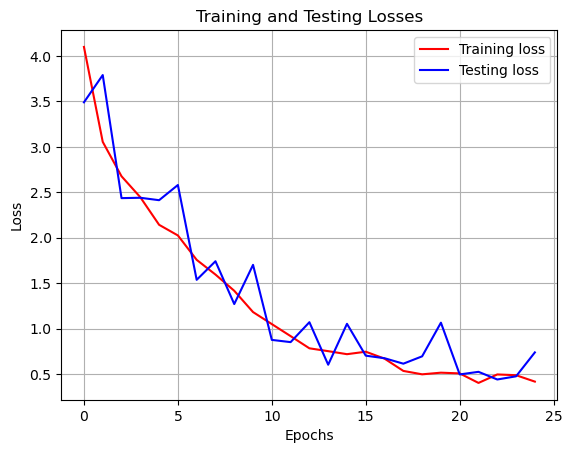

In [25]:
epochs = range(0, num_epochs)
plt.plot(epochs, training_losses, 'r', label='Training loss')
plt.plot(epochs, testing_losses, 'b', label='Testing loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')

plt.grid()
plt.legend()
plt.show()

In [26]:
new_dir = Path("C:/Users/Michał/Documents/ISWD/saved models")
os.chdir(new_dir)
tc.save(classification_model.state_dict(), "classification_model.pt")

current_dir = os.getcwd()
files = os.listdir(current_dir)
model_filename = 'classification_model.pt'
if model_filename in files:
    print(f'Saved model file {model_filename} found in {current_dir}.')
else:
    print(f'Saved model file {model_filename} not found in {current_dir}.')

Saved model file classification_model.pt found in C:\Users\Michał\Documents\ISWD\saved models.


In [ ]:
improved_classification_model, training_losses, testing_losses = training(improved_classification_network, training_dataloader, validation_dataloader, num_epochs, learning_rate)

In [ ]:
epochs = range(0, num_epochs)
plt.plot(epochs, training_losses, 'r', label='Training loss')
plt.plot(epochs, testing_losses, 'b', label='Testing loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')

plt.grid()
plt.legend()
plt.show()

In [ ]:
new_dir = Path("C:/Users/Michał/Documents/ISWD/saved models")
os.chdir(new_dir)
tc.save(improved_classification_model.state_dict(), "improved_classification_model.pt")

current_dir = os.getcwd()
files = os.listdir(current_dir)
model_filename = 'improved_classification_model.pt'
if model_filename in files:
    print(f'Saved model file {model_filename} found in {current_dir}.')
else:
    print(f'Saved model file {model_filename} not found in {current_dir}.')

# Evaluation

In [27]:
device = "cuda:0" if tc.cuda.is_available() else "cpu"
new_dir = Path("C:/Users/Michał/Documents/ISWD/saved models")
os.chdir(new_dir)

classification_model = ClassificationNetwork().to(device)
classification_model.load_state_dict(tc.load('classification_model.pt'))

# improved_classification_model = ImprovedClassificationNetwork().to(device)
# improved_classification_model.load_state_dict(tc.load('improved_classification_model.pt'))

<All keys matched successfully>

In [28]:
def accumulate_predictions(model, dataloader):
  predictions = []
  targets = []
  
  model.eval()
  with tc.set_grad_enabled(False):
      print(f"Dataset size: {len(dataloader.dataset)}")
      for images, classes in dataloader:
        images = images.to(device)
        classes = classes.to(device)

        output = model(images)
        pred = output.argmax(dim=1)

        predictions.append(pred.cpu())
        targets.append(classes.cpu())
  predictions = tc.cat(predictions)
  targets = tc.cat(targets)
  return predictions, targets

Dataset size: 3430
Dataset size: 981
Training Accuracy: 0.8279883381924198
Testing Accuracy: 0.7920489296636085
Training Report:
Testing Report:


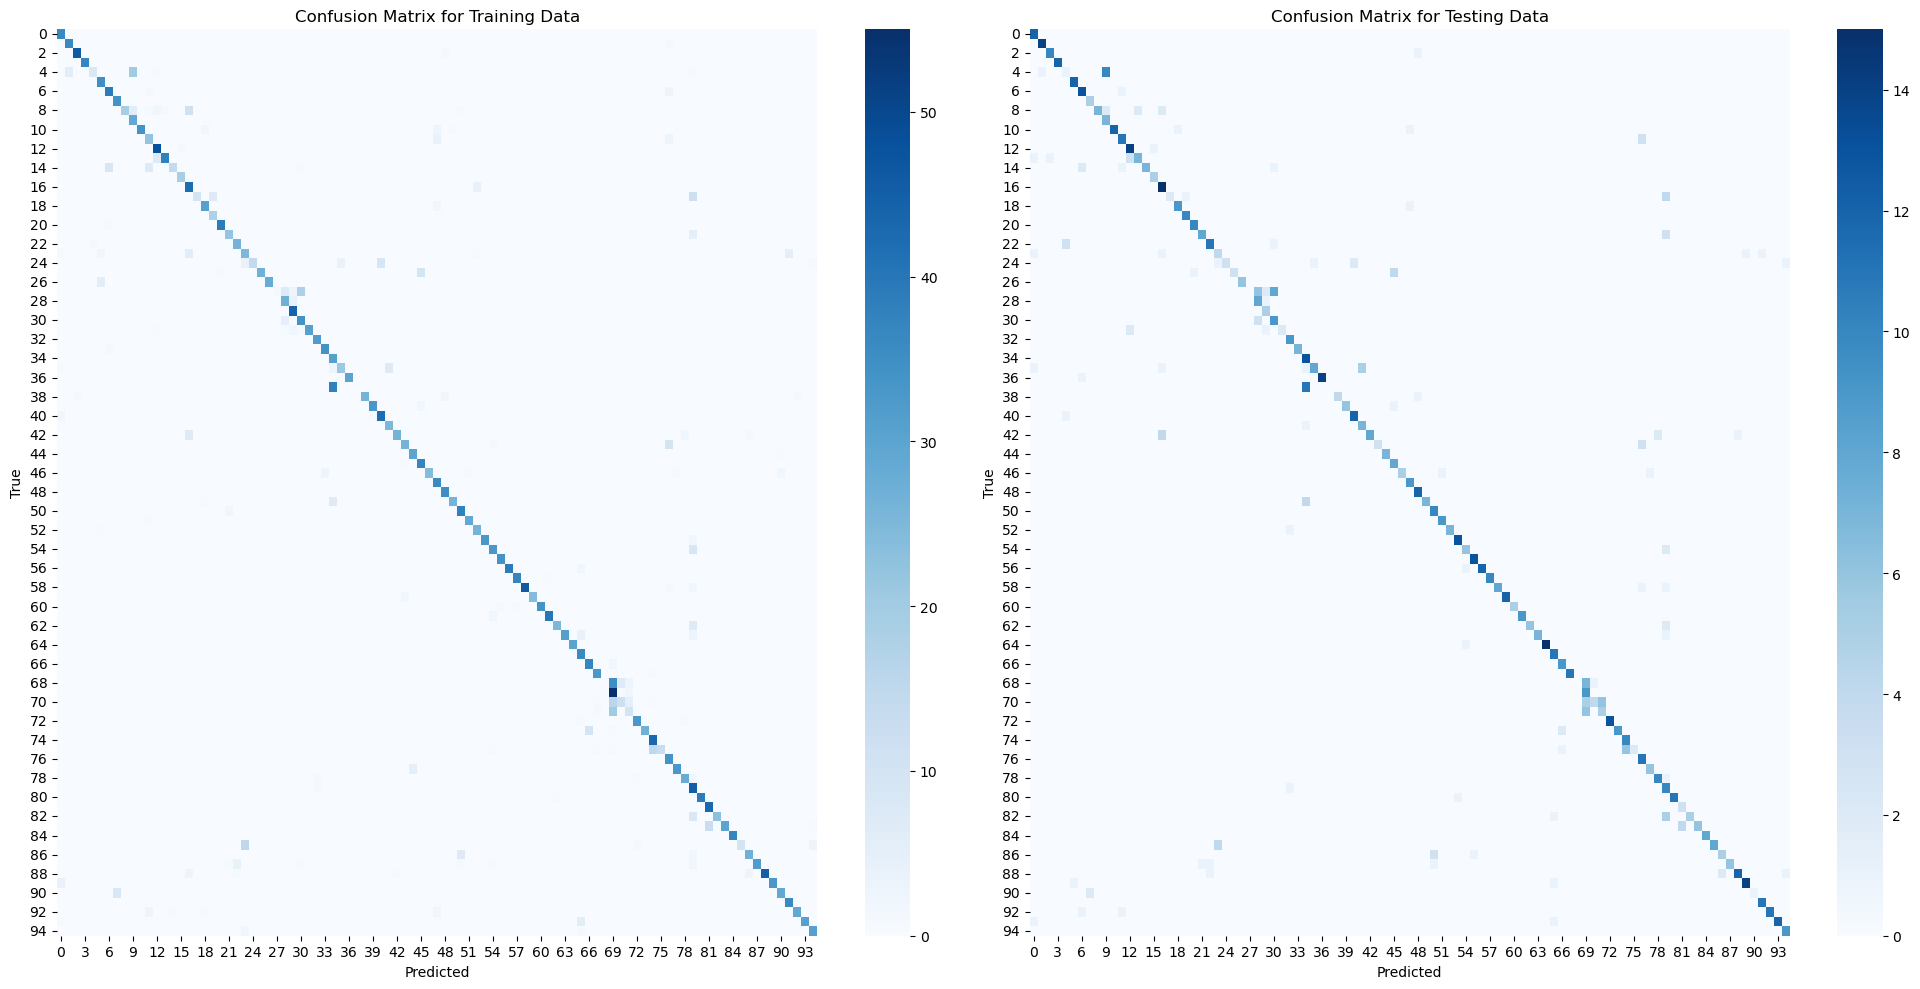

In [29]:
training_predictions, training_targets = accumulate_predictions(classification_model, training_dataloader)
testing_predictions, testing_targets =  accumulate_predictions(classification_model, testing_dataloader)

training_cm = metrics.confusion_matrix(training_targets, training_predictions)
testing_cm = metrics.confusion_matrix(testing_targets, testing_predictions)

# Calculate accuracy and sensitivity for training data
training_accuracy = metrics.accuracy_score(training_targets, training_predictions)
#training_report = classification_report(training_targets, training_predictions, target_names=classes)

# Calculate accuracy and sensitivity for testing data
testing_accuracy = metrics.accuracy_score(testing_targets, testing_predictions)
#testing_report = classification_report(testing_targets, testing_predictions, target_names=classes)

print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

print("Training Report:")
#print(training_report)
print("Testing Report:")
#print(testing_report)

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # Adjust the figsize as per your needs

# Plot the confusion matrix for training data
sns.heatmap(training_cm, cmap='Blues', ax=axs[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
axs[0].set_title('Confusion Matrix for Training Data')

# Plot the confusion matrix for testing data
sns.heatmap(testing_cm, cmap='Blues', ax=axs[1])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
axs[1].set_title('Confusion Matrix for Testing Data')

plt.tight_layout()  # Adjust the spacing between subplots

plt.show()

In [ ]:
training_predictions, training_targets = accumulate_predictions(improved_classification_model, training_dataloader)
testing_predictions, testing_targets =  accumulate_predictions(improved_classification_model, testing_dataloader)

training_cm = metrics.confusion_matrix(training_targets, training_predictions)
testing_cm = metrics.confusion_matrix(testing_targets, testing_predictions)

# Calculate accuracy and sensitivity for training data
training_accuracy = metrics.accuracy_score(training_targets, training_predictions)
#training_report = classification_report(training_targets, training_predictions, target_names=classes)

# Calculate accuracy and sensitivity for testing data
testing_accuracy = metrics.accuracy_score(testing_targets, testing_predictions)
#testing_report = classification_report(testing_targets, testing_predictions, target_names=classes)

print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

print("Training Report:")
#print(training_report)
print("Testing Report:")
#print(testing_report)

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # Adjust the figsize as per your needs

# Plot the confusion matrix for training data
sns.heatmap(training_cm, cmap='Blues', ax=axs[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
axs[0].set_title('Confusion Matrix for Training Data')

# Plot the confusion matrix for testing data
sns.heatmap(testing_cm, cmap='Blues', ax=axs[1])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
axs[1].set_title('Confusion Matrix for Testing Data')

plt.tight_layout()  # Adjust the spacing between subplots

plt.show()